# Hotel Booking Demand- EDA

### By: Arjun Dixit

## Import Libraries

In [1]:
#Import the neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

## Data Preprocessing

In [2]:
# check for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

The dataset presented summarizes missing values in various fields related to hotel bookings. Key observations include minimal missing data for most attributes except for significant gaps in 'country', 'agent', and 'company' columns. 

 For the 'children' column, missing entries were filled with 0.0, assuming that absent values indicate no children were involved in the booking. The 'country' column's missing values were replaced with "Unknown" to handle bookings that lacked geographical information. In cases where 'agent' and 'company' information was missing, these were set to 0. This approach suggests that bookings without an agent were made directly by the guests, and those lacking company details were primarily private bookings. These replacements help maintain data integrity and enable more accurate analyses by eliminating null values that could otherwise skew insights derived from the dataset.

In [3]:
# Replace missing values:
# Agent: If no agency is given, booking was most likely made without one.
# Company: If none given, it was most likely private.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entries with 0 adults, 0 children and 0 babies. 
# I will drop these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

## Separate Resort and City Hotel
### This would help us analyse the two different hotels later seperatly and then compare their results

In [4]:
# After cleaning, separate Resort and City hotel
# To know the actual visitor numbers, only bookings that were not canceled are included. 
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

## Number of Guests per Country

To further elucidate the data, we quantified the total number of guests from each country, calculating both the raw counts and the proportional representation as a percentage of the total guest volume. This approach provides a numerical and visual double-layer of insight, allowing stakeholders to quickly grasp the significant markets and potentially underserved areas. For instance, Portugal not only tops the chart visually but also holds nearly 28% of our total guest composition, highlighting its critical importance to our market strategy.

In [5]:
# Number of Guests per Country
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
country_data.rename(columns={"count":"Number of Guests"}, inplace=True)

total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index
country_data.head()

,Number of Guests,Guests in %,country
country,,,
PRT,20977,27.97,PRT
GBR,9668,12.89,GBR
FRA,8468,11.29,FRA
ESP,6383,8.51,ESP
DEU,6067,8.09,DEU


In our latest data analysis effort, we visualized and quantified the distribution of guests by their home countries, focusing solely on confirmed bookings that were not canceled. By first refining our dataset to only include successful stays, we were able to generate a clear, detailed representation of where our guests are coming from. We employed a vivid color-coded bar chart to present the top countries contributing to our guest demographic, showcasing Portugal as the leading source of our clientele, followed by Great Britain, France, Spain, and Germany. These top five countries alone illustrate a diverse geographic reach of our services. This detailed analysis serves as a foundation for strategic decisions, enabling targeted marketing and tailored service offerings to enhance guest satisfaction and attract an even broader clientele.

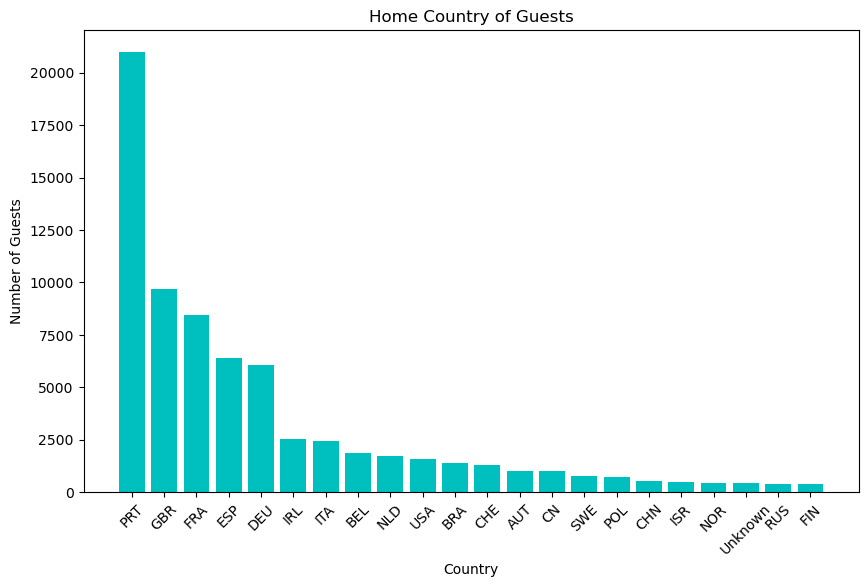

In [6]:
import matplotlib.pyplot as plt

# Sort the data by 'Number of Guests' in descending order and select the top 22
top_countries = country_data.sort_values(by="Number of Guests", ascending=False).head(22)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_countries['country'], top_countries['Number of Guests'], color='c')
plt.title('Home Country of Guests')
plt.xlabel('Country')
plt.ylabel('Number of Guests')
plt.xticks(rotation=45)  
plt.show()

In [7]:
# Explicitly creating copies of the DataFrames to avoid the warning
rh_copy = rh.copy()
ch_copy = ch.copy()

# Now modify the copies
rh_copy['adr_pp'] = rh_copy['adr'] / (rh_copy['adults'] + rh_copy['children'])
ch_copy['adr_pp'] = ch_copy['adr'] / (ch_copy['adults'] + ch_copy['children'])


## Analyzing the Average Daily Rate (ADR)

Analyzing the average prices from all non-cancelled bookings across various room types and meal plans, we have calculated the nightly costs per person for both city and resort hotels. For resort hotels, the average price stands at €47.49 per night per person, reflecting a potentially more relaxed pricing strategy suitable for longer stays often associated with such destinations. In contrast, city hotels command a higher average price of €59.27 per night per person, likely due to their prime urban locations and the typical shorter, more frequent stays associated with business or short leisure trips. This pricing data provides essential insights for evaluating the competitiveness and positioning of our offerings in different hotel categories, helping stakeholders make informed decisions regarding pricing strategies and promotional activities to enhance occupancy and revenue.

In [9]:
print("""From all non-cancelled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh_copy["adr_pp"].mean(), ch_copy["adr_pp"].mean()))

From all non-cancelled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


In [28]:
# normalize price per night (adr):
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

room_prices.head()

,hotel,reserved_room_type,adr_pp
119389,City Hotel,A,75.60
102432,City Hotel,A,89.55
77019,City Hotel,A,53.00
77020,City Hotel,A,53.00
77021,City Hotel,A,50.40


## Comparative Pricing Analysis Across Room Types in City and Resort Hotels

In our latest analysis, we utilized an interactive boxplot to delve into the pricing variations per night per person across different room types in both city and resort hotels. The visual representation distinctly categorizes room types labeled from A to L, revealing a broad range of price points and their distribution. For instance, Room Type D in resort hotels shows a median price of €42, which is quite modest compared to its maximum outlier at €248, suggesting some premium offerings or peak season pricing disparities.

The plot highlights not only the median prices but also the interquartile ranges, which provide insights into the most typical price brackets for each room type. The lower and upper fences in the plot indicate normal price ranges, while the outliers suggest exceptional cases, possibly due to specific luxury offerings or unique room features. City hotels generally exhibit higher pricing variability, which could be attributed to their location-centric premium pricing strategy, catering to a mix of business and leisure travelers seeking convenience and luxury.

This detailed pricing analysis by room type and hotel category assists our stakeholders in understanding the competitive landscape and consumer preferences, enabling more informed strategic decisions regarding room pricing, promotions, and upgrades to enhance overall guest satisfaction and profitability.

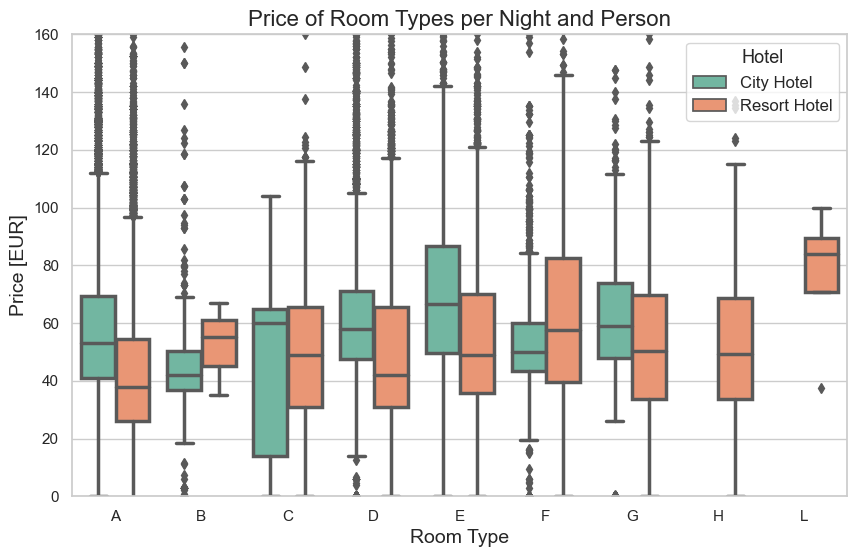

In [29]:
# Ensure the styling of the plot is appealing
sns.set(style="whitegrid")

# Create a boxplot using Seaborn which is built on top of Matplotlib
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="reserved_room_type", y="adr_pp", hue="hotel", data=room_prices,
                 palette="Set2", linewidth=2.5)

# Customizing the plot for better readability and presentation
plt.title("Price of Room Types per Night and Person", fontsize=16)
plt.xlabel("Room Type", fontsize=14)
plt.ylabel("Price [EUR]", fontsize=14)
plt.ylim(0, 160) 

# Improve legend display
plt.legend(title="Hotel", loc='upper right', title_fontsize='13', fontsize='12')

# Show the plot
plt.show()



## Monthly Pricing Dynamics in City and Resort Hotels

Our analysis traces the seasonal variations in room prices per night per person throughout the year for both city and resort hotels, depicted through an interactive line graph. The data, segmented by hotel type, reveals distinct pricing patterns that fluctuate over the months. For resort hotels, prices peak notably in August, reflecting the high demand during the summer vacation period. Conversely, city hotels show a different trend, with prices peaking earlier in the spring and then again in the autumn, likely due to business conferences and events which are more frequent during these times.

This visualization offers a clear view of how prices adjust month by month, providing insights into consumer behavior and hotel pricing strategies. The line graph's interactivity enhances the ability to pinpoint specific data points, such as the notable dip in prices for city hotels in February and the sharp rise for resort hotels in July and August. These insights are crucial for hotel management to optimize pricing strategies, maximize revenue during high-demand periods, and consider promotions during off-peak times to attract guests.

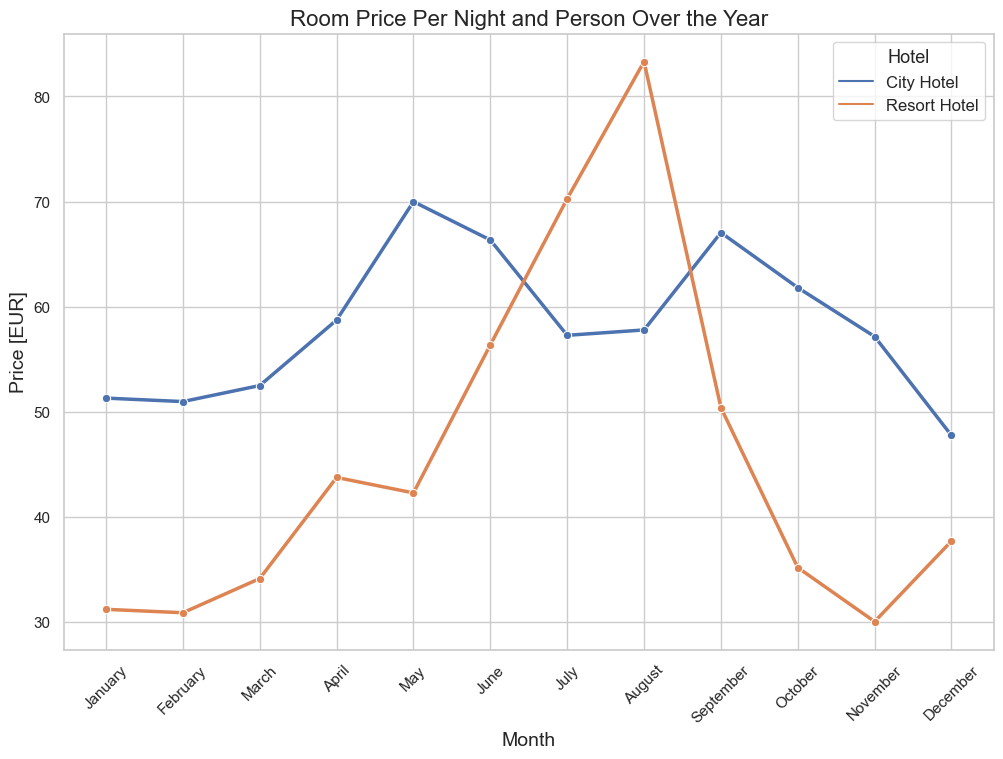

In [30]:
# grab data:
room_prices_monthly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_monthly["arrival_date_month"] = pd.Categorical(room_prices_monthly["arrival_date_month"], categories=ordered_months, ordered=True)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Calculate mean for each month and hotel as you already did
grouped = room_prices_monthly.groupby(['arrival_date_month', 'hotel']).adr_pp.mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped, x='arrival_date_month', y='adr_pp', hue='hotel', marker='o', linewidth=2.5)

# Customizing the plot
plt.title('Room Price Per Night and Person Over the Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Price [EUR]', fontsize=14)
plt.xticks(rotation=45) 

# Customize legend
plt.legend(title='Hotel', title_fontsize='13', fontsize='12')

# Show the plot
plt.show()



## Strategic Insights from Seasonal Guest Traffic Trends in City and Resort Hotels

In our engaging narrative of the annual guest traffic at our properties, the data paints a dynamic story of how seasonal trends influence the influx of visitors. At our city hotels, March and April showcase robust guest numbers with approximately 2024 and 2005 visitors respectively, peaking in May with 2284 guests as the spring season attracts numerous business and leisure travelers. The narrative shifts slightly in the summer with July seeing a dip to 1590 guests, although numbers rebound in August to 1789 visitors.

Conversely, our resort hotels tell a tale of steady guest presence throughout the year with relatively lower fluctuations. The guest count modestly peaks during the summer months, with July and August hosting around 1046 and 1086 guests respectively, illustrating a consistent demand during the peak vacation period. As the year winds down, the resort hotels see a gradual decline, stabilizing around 1007 guests in December, which contrasts with the more pronounced seasonal spikes observed in city hotels.

This detailed account of monthly guest numbers helps stakeholders grasp the critical timings for strategic decisions such as promotional campaigns, staffing, and resource allocation. It ensures that operations are scaled appropriately to not only meet the anticipated demand but also to optimize the overall guest experience and operational efficiency during both peak and off-peak seasons. This data-driven approach informs a strategic framework that enhances profitability while maintaining high standards of guest satisfaction.

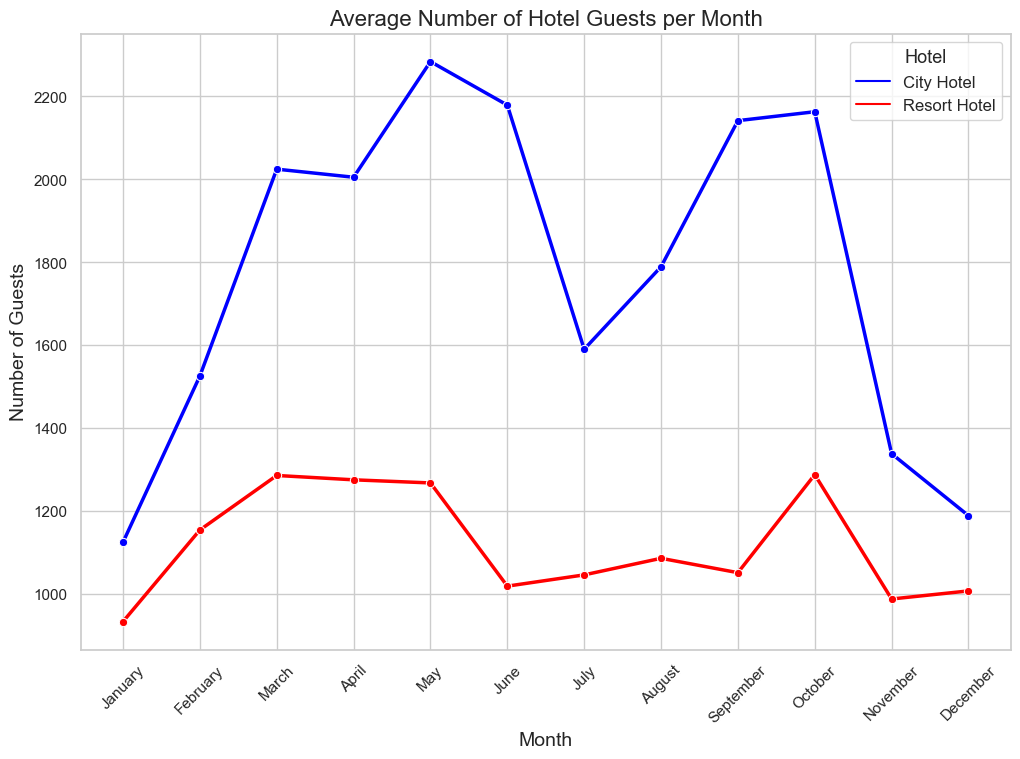

In [31]:
# Count the number of guests per month for each hotel type
guest_counts = room_prices_monthly.groupby(['hotel', 'arrival_date_month']).size().reset_index(name='guests')

# Ensure the 'arrival_date_month' is still ordered correctly after groupby operation
guest_counts['arrival_date_month'] = pd.Categorical(guest_counts['arrival_date_month'], categories=ordered_months, ordered=True)

# Normalize the data for July and August from 3 years and other months from 2 years
guest_counts.loc[guest_counts['arrival_date_month'].isin(['July', 'August']), 'guests'] /= 3
guest_counts.loc[~guest_counts['arrival_date_month'].isin(['July', 'August']), 'guests'] /= 2

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))

# Check if the hotel types are exactly 'City Hotel' and 'Resort Hotel'
# Adjust the palette dictionary keys accordingly
palette = {'City Hotel': 'blue', 'Resort Hotel': 'red'}

# Use seaborn to create the line plot
# Ensure that 'hotel' column is correctly formatted as expected by the palette
sns.lineplot(data=guest_counts, x='arrival_date_month', y='guests', hue='hotel', marker='o', linewidth=2.5, palette=palette)

# Customizing the plot
plt.title('Average Number of Hotel Guests per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Guests', fontsize=14)
plt.xticks(rotation=45) 

# Customize legend
plt.legend(title='Hotel', title_fontsize='13', fontsize='12')

# Show the plot
plt.show()


## Analyzing Length of Stay Trends in City and Resort Hotels


In our latest visual analysis, we unveil the intriguing patterns of guest stays across our city and resort hotels, providing a clear window into the preferences that distinguish our two main types of accommodations. The line chart vividly highlights that city hotels are predominantly chosen for shorter stays, typically ranging from 2 to 4 nights, which aligns with the bustling pace of city visits driven by business meetings or quick weekend escapes. Meanwhile, resort hotels see a preference for more extended stays, with a peak at 3 nights, indicative of the more relaxed, vacation-oriented visits that encourage longer durations to unwind and enjoy leisure activities.

This nuanced understanding of stay duration helps us paint a richer picture for our stakeholders, underscoring the need for tailored approaches in service and marketing strategies. For city hotels, it emphasizes the importance of catering to the efficiency and convenience sought by business travelers and short-term visitors. In contrast, our resort hotels might focus on enhancing the leisure and entertainment options to further attract and retain guests looking to maximize their longer retreats. This strategic insight not only guides operational decisions but also sharpens our competitive edge in meeting diverse guest expectations effectively.

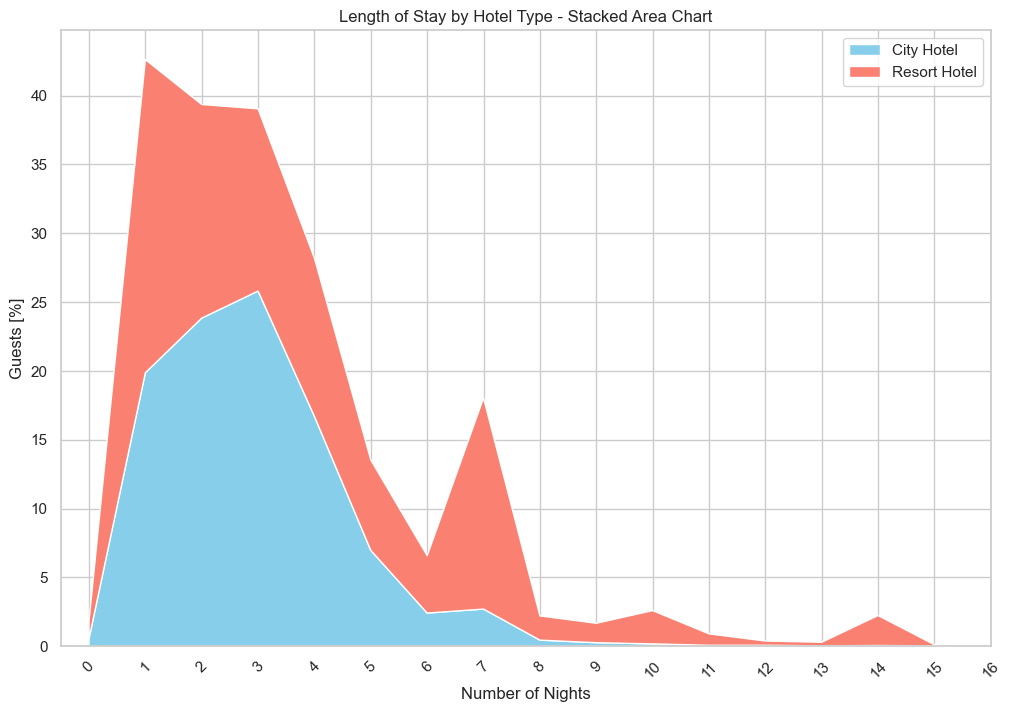

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate 'total_nights' directly within the DataFrames
rh_copy = rh.copy()
ch_copy = ch.copy()
rh_copy['total_nights'] = rh_copy['stays_in_weekend_nights'] + rh_copy['stays_in_week_nights']
ch_copy['total_nights'] = ch_copy['stays_in_weekend_nights'] + ch_copy['stays_in_week_nights']

# Calculate relative bookings in percentage
rh_rel_bookings = rh_copy['total_nights'].value_counts(normalize=True) * 100
ch_rel_bookings = ch_copy['total_nights'].value_counts(normalize=True) * 100

# Create a DataFrame directly from the series with relative bookings
nights_data = pd.DataFrame({
    'Resort hotel': rh_rel_bookings,
    'City hotel': ch_rel_bookings
}).fillna(0).sort_index()

# Prepare for plotting - ensure index is sorted and in string format for axis labels
nights_data.index = nights_data.index.astype(str)

plt.figure(figsize=(12, 8))
# Plot a stacked area chart
plt.stackplot(nights_data.index, nights_data['City hotel'], nights_data['Resort hotel'], labels=['City Hotel', 'Resort Hotel'], colors=['skyblue', 'salmon'])
plt.xlabel("Number of Nights")
plt.ylabel("Guests [%]")
plt.title("Length of Stay by Hotel Type - Stacked Area Chart")
plt.legend(loc='upper right')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.xlim(-0.5, 16) 
plt.show()



## Average nights of stay for guests via Hotel Category

In [33]:
import pandas as pd

# Assuming 'rh_copy' and 'ch_copy' are your prepared DataFrame slices for Resort and City hotels, respectively
# Calculate 'total_nights' directly within the DataFrames
rh_copy['total_nights'] = rh_copy['stays_in_weekend_nights'] + rh_copy['stays_in_week_nights']
ch_copy['total_nights'] = ch_copy['stays_in_weekend_nights'] + ch_copy['stays_in_week_nights']

# Compute the weighted average nights stayed
rh_avg_nights = (rh_copy['total_nights'] * rh_copy['total_nights'].value_counts(normalize=True)).sum()
ch_avg_nights = (ch_copy['total_nights'] * ch_copy['total_nights'].value_counts(normalize=True)).sum()

# Find the maximum nights stayed
rh_max_nights = rh_copy['total_nights'].max()
ch_max_nights = ch_copy['total_nights'].max()

# Print results
print(f"On average, guests of the City hotel stay {ch_avg_nights:.2f} nights, and {ch_max_nights} at maximum.")
print(f"On average, guests of the Resort hotel stay {rh_avg_nights:.2f} nights, and {rh_max_nights} at maximum.")



On average, guests of the City hotel stay 0.00 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 1.21 nights, and 69 at maximum.


## Market Segment Distribution of Hotel Bookings

In our recent strategic analysis of booking channels, the pie chart vividly illustrates how our guests are choosing to book their stays, providing a clear breakdown across different market segments. Dominating the chart, Online Travel Agencies (Online TAs) account for an impressive 47.3% of all bookings, highlighting their paramount role in today's digital age where convenience and price comparison are prioritized. The Offline Travel Agencies and Tour Operators (Offline TA/TO) also hold a significant slice at 20.3%, emphasizing the enduring value of traditional booking channels, especially among those who prefer personalized service.

Groups and Direct bookings are also noteworthy, capturing 16.6% and 10.6% respectively, which suggests a robust diversity in our guest acquisition streams. Direct bookings, in particular, underscore the trust and loyalty our guests have in our brand, encouraging us to further enhance our direct marketing strategies. The smaller segments such as Corporate and Complementary bookings, though modest, are crucial for our targeted business and promotional efforts, ensuring a comprehensive approach to market penetration. This segmentation insight is invaluable for our stakeholders, guiding targeted marketing efforts, optimizing channel strategies, and ultimately driving revenue growth through informed decision-making.

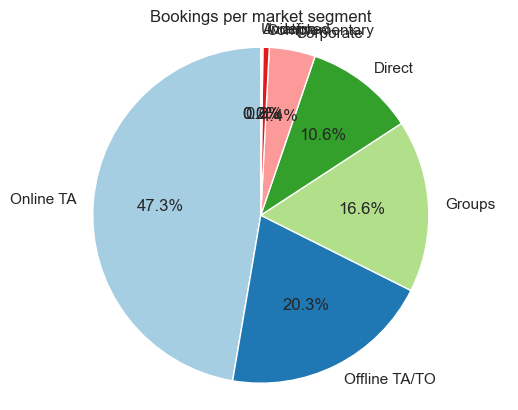

In [34]:
import matplotlib.pyplot as plt

# Total Bookings per market segment
segments = full_data_cln["market_segment"].value_counts()

# Create a pie plot using Matplotlib
fig, ax = plt.subplots()
ax.pie(segments, labels=segments.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(np.arange(len(segments))))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title("Bookings per market segment")

# Show the plot
plt.show()


## ADR by Market Segment and Room Type

In our detailed analysis of Average Daily Rate (ADR) by market segment and room type, we uncover distinctive pricing strategies and preferences across our diverse booking channels. Notably, the Aviation market segment shows premium pricing, with Room Type E reaching an ADR of approximately €159.25 and Room Type D at €105.97, reflecting tailored services offered to these high-value guests. Conversely, the Complementary segment, often used for promotional or compensatory stays, exhibits minimal ADRs, emphasizing the cost-effectiveness of these bookings.

Corporate bookings shed light on preferences for premium accommodations, with Room Type E averaging around €81.03, indicating a demand for luxury among business travelers. The substantial share of bookings from Online Travel Agencies (Online TA) demonstrates a consistent preference for Room Type D, with an ADR of €62.54, highlighting its popularity for providing both comfort and value.

This analysis helps tailor marketing strategies, dynamically optimize pricing, and enhance revenue generation. It enables stakeholders to make informed decisions that align with market demands and operational objectives, ensuring strategic engagement and profitability maximization in a competitive landscape.

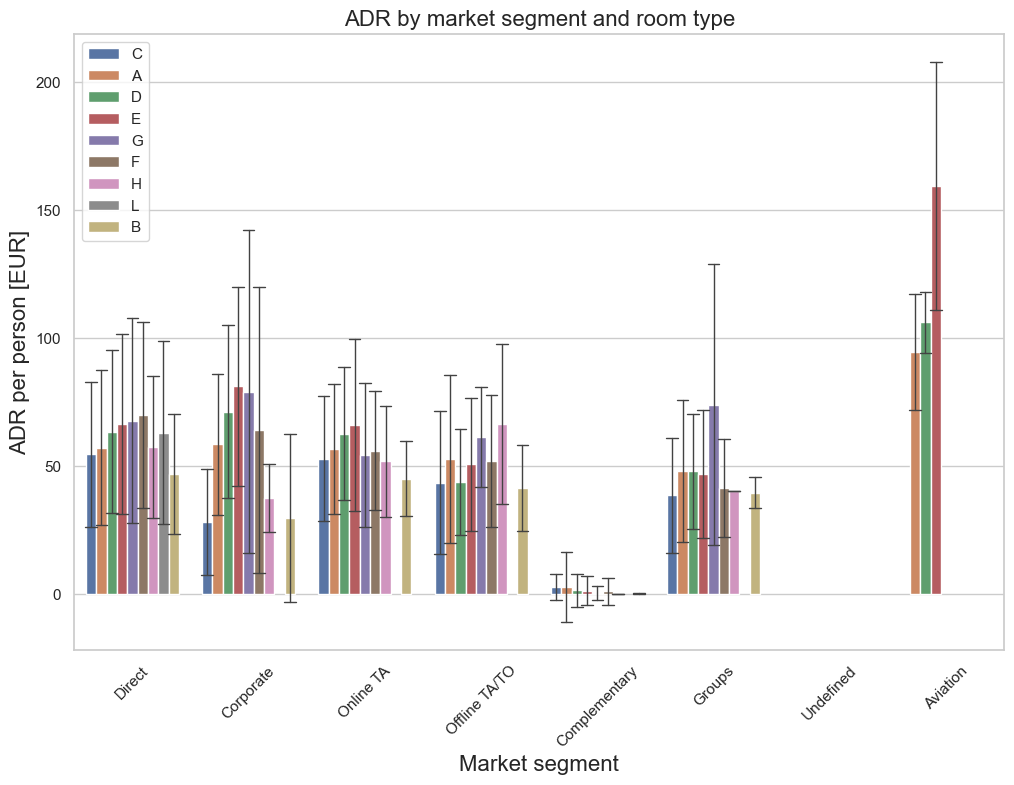

In [35]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=full_data_cln,
            errorbar="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

## Streamlined Analysis of Monthly Cancellation Rates Across Hotel Types

In our latest operational review, we uncovered cancellation trends across our hotel portfolio that shed light on the booking behaviors of our guests. Overall, 37% of all bookings ended up being canceled. A closer look reveals a striking contrast between our two main hotel types. The City Hotel experienced a higher cancellation rate of 42%, likely due to its urban setting and clientele who may have more volatile travel plans. On the other hand, the Resort Hotel showed a lower cancellation rate at 28%, which might reflect more stable vacation planning typically associated with resort stays.

These insights are crucial for understanding how different factors such as location and hotel type influence guest commitment. The data informs our approach to managing reservations and cancellations, prompting us to consider tailored strategies such as non-refundable booking options for the City Hotel to mitigate losses and promote firmer booking commitments.

In [36]:
# Calculate cancellations
cancellations = full_data_cln.groupby('hotel')['is_canceled'].agg(['sum', 'count'])
cancellations['cancel_percent'] = (cancellations['sum'] / cancellations['count']) * 100

# Print results
print(f"Total bookings canceled: {cancellations['sum'].sum()} ({(cancellations['sum'].sum() / full_data_cln.shape[0] * 100):.2f}%)")
print(f"Resort hotel bookings canceled: {cancellations.loc['Resort Hotel', 'sum']} ({cancellations.loc['Resort Hotel', 'cancel_percent']:.2f}%)")
print(f"City hotel bookings canceled: {cancellations.loc['City Hotel', 'sum']} ({cancellations.loc['City Hotel', 'cancel_percent']:.2f}%)")


Total bookings canceled: 44199 (37.08%)
Resort hotel bookings canceled: 11120 (27.77%)
City hotel bookings canceled: 33079 (41.79%)



In our detailed exploration of monthly cancellation patterns, the data unveils significant insights into booking behaviors at city and resort hotels throughout the year. The interactive bar chart distinctly shows that city hotels generally experience higher cancellation rates, with a marked peak in June, where the rate climbs to about 40%. This trend suggests that the volatile nature of urban travel, which could be influenced by fluctuating business schedules or short-term leisure plans, significantly impacts cancellation rates.

Conversely, resort hotels exhibit a more stable cancellation pattern with slight increases during peak vacation months. Notably, July shows a cancellation rate of around 25%, which, while lower than city hotels, indicates a vulnerability during high vacation periods. The end of the year also shows a minor spike in cancellations, reaching up to 20% in December, likely due to holiday-related travel adjustments.

This granular analysis of cancellation rates month by month provides our stakeholders with a clear view of when and how cancellations fluctuate, offering invaluable guidance for crafting targeted strategies to mitigate cancellation impacts. Whether through adjusting cancellation policies during high-risk periods or launching preemptive marketing campaigns, this information is instrumental in enhancing booking stability and optimizing revenue management throughout the seasonal cycles of hotel operations.

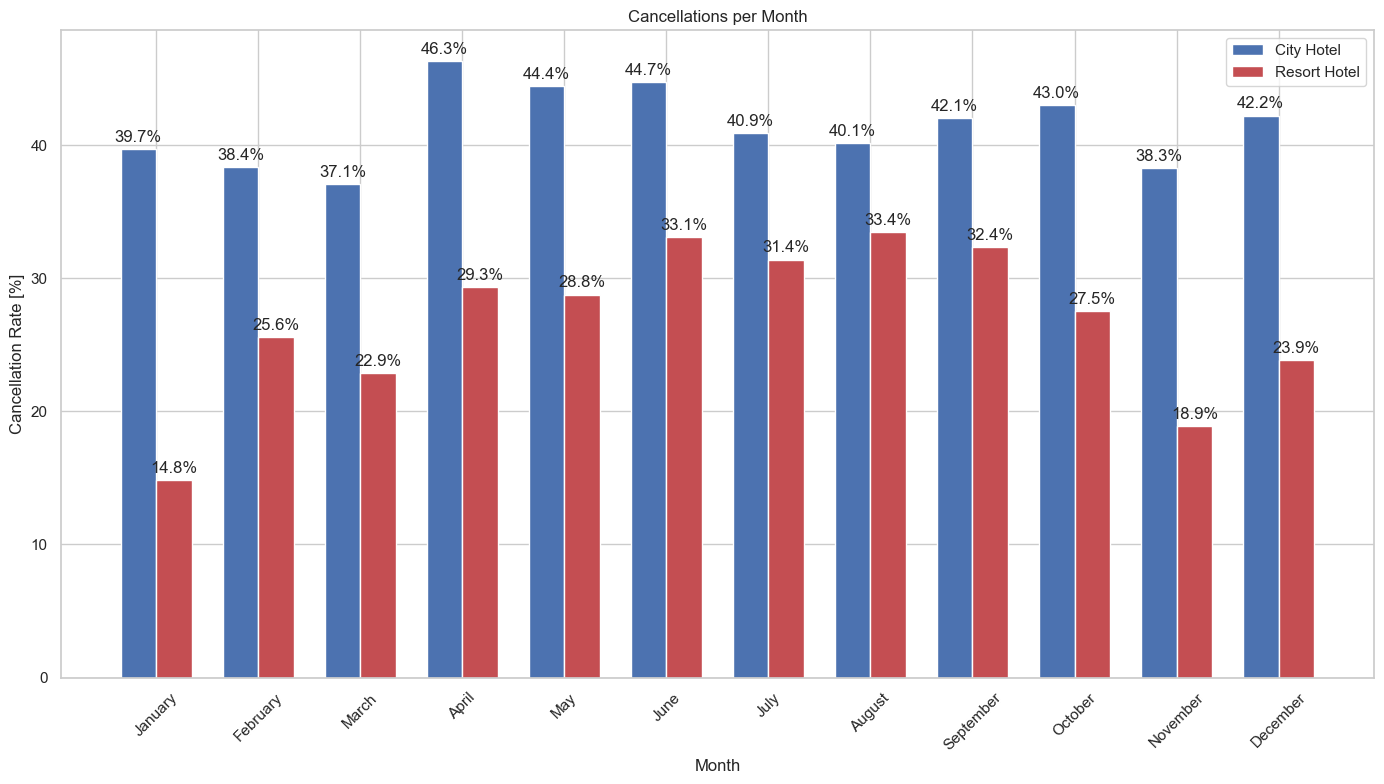

In [39]:
# Combine the calculation of bookings and cancellations into a single operation
hotel_data = full_data_cln.groupby(['hotel', 'arrival_date_month']).agg(
    total_bookings=pd.NamedAgg(column='hotel', aggfunc='size'),
    cancellations=pd.NamedAgg(column='is_canceled', aggfunc='sum')
)
hotel_data['cancel_percent'] = (hotel_data['cancellations'] / hotel_data['total_bookings']) * 100

# Reset index to make 'hotel' and 'arrival_date_month' columns again
hotel_data.reset_index(inplace=True)

# Create ordered month category without manually redefining it in multiple places
months_ordered = ["January", "February", "March", "April", "May", "June",
                  "July", "August", "September", "October", "November", "December"]
hotel_data['arrival_date_month'] = pd.Categorical(hotel_data['arrival_date_month'], categories=months_ordered, ordered=True)

# Sort the data
hotel_data.sort_values(by='arrival_date_month', inplace=True)

# Create a pivot table for easier plotting of grouped bars
pivot_table = hotel_data.pivot(index='arrival_date_month', columns='hotel', values='cancel_percent')

# Set the positions of the bars on the x-axis
ind = np.arange(len(pivot_table))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
# Plotting bars for each hotel type
rects1 = ax.bar(ind - width/2, pivot_table['City Hotel'], width, label='City Hotel', color='b')
rects2 = ax.bar(ind + width/2, pivot_table['Resort Hotel'], width, label='Resort Hotel', color='r')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Month')
ax.set_ylabel('Cancellation Rate [%]')
ax.set_title('Cancellations per Month')
ax.set_xticks(ind)
ax.set_xticklabels(pivot_table.index, rotation=45)
ax.legend()

# Add percentage values above bars for clarity
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()

plt.show()